<a href="https://colab.research.google.com/github/oguiza/timeseries/blob/master/tutorial_nbs/06_TS_to_image_classification_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@gmail.com

## Introduction

Sometimes it may be useful to transform a univariate or multivariate time series into an image so that any of the techniques available for images can be used. 

These images can be created "on the fly" by transforms that work in the same way as any other transforms in fastai. I've added a few of these transforms to the tsai library. Most of the transforms come from the excellent `pyts` library (for more information please visit https://pyts.readthedocs.io).

I'd like to warn you up from that the transform of a TS to an image "on the fly" is slow, and can make you training way too long. If you are still interested in using TS as images, you may test wich ones work best on a small subset, and then create and save the output as images. You can then use a regular vision dataloader to train a vision model. 

## Import libraries

In [1]:
bleeding = True # True: latest version, False: latest stable version

import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if bleeding:
        !pip install git+https://github.com/fastai/fastcore.git@master -q
        !pip install git+https://github.com/fastai/fastai.git@master -q
        !pip install git+https://github.com/timeseriesAI/timeseriesAI.git -q
    else: 
        !pip install tsai -q
    
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
print('matplotlib :', matplotlib.__version__)

tsai       : 0.2.0
fastai     : 2.0.18
fastcore   : 1.2.5
torch      : 1.6.0
scipy      : 1.5.2
numpy      : 1.19.1
pandas     : 1.1.3
matplotlib : 3.3.2


## Available TS to Image transforms

The following time series to image transforms are available in the tsai library:

* **TSToPlot**: creates a matplotlib line plot
* **TSToMat**: creates a matplotlib imshow plot
* **TSToGADF**: creates an image based on a Gramian Angular Difference Filed transformation
* **TSToGASF**: creates an image based on a Gramian Angular Summation Filed transformation
* **TSToMTF**: creates an image based on a Markov Transition Field transformation
* **TSToRP**: creates an image based on a Recurrence Plot transformation

All transforms can be used with **univariate or multivariate time series**.



tfm: TSToPlot - batch shape: torch.Size([64, 3, 224, 224])


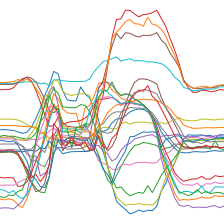



tfm: TSToMat - batch shape: torch.Size([64, 3, 224, 224])


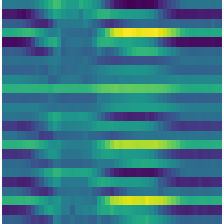



tfm: TSToGADF - batch shape: torch.Size([64, 24, 224, 224])


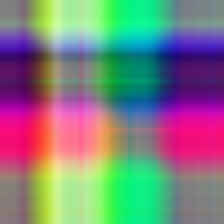



tfm: TSToGASF - batch shape: torch.Size([64, 24, 224, 224])


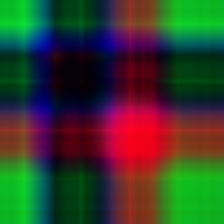



tfm: TSToMTF - batch shape: torch.Size([64, 24, 224, 224])


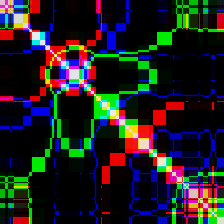



tfm: TSToRP - batch shape: torch.Size([64, 24, 224, 224])


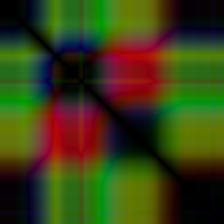

In [49]:
dsid = 'NATOPS' # multivariate dataset
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', return_split=False)
tfms = [None, Categorize()]
bts = [[TSNormalize(), TSToPlot()], 
       [TSNormalize(), TSToMat(cmap='viridis')],
       [TSNormalize(), TSToGADF(cmap='spring')],
       [TSNormalize(), TSToGASF(cmap='summer')],
       [TSNormalize(), TSToMTF(cmap='autumn')],
       [TSNormalize(), TSToRP(cmap='winter')]]
btns = ['Plot', 'Mat', 'GADF', 'GASF', 'MTF', 'RP']
for i, (bt, btn) in enumerate(zip(bts, btns)):
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=[64, 128],
                                   batch_tfms=bt,
                                   shuffle=False)
    xb, yb = dls.train.one_batch()
    print(f'\n\ntfm: TSTo{btn} - batch shape: {xb.shape}')
    xb[0].show()
    plt.show()

## Univariate time series

Let's first see how all these transforms can be applied to univariate time series. 

In [19]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', return_split=False)
epochs = 200

### Raw data (InceptionTime)

As a benchmark, we'll first train a state-of-the-art TS model (Inceptiontime) that uses raw data. 

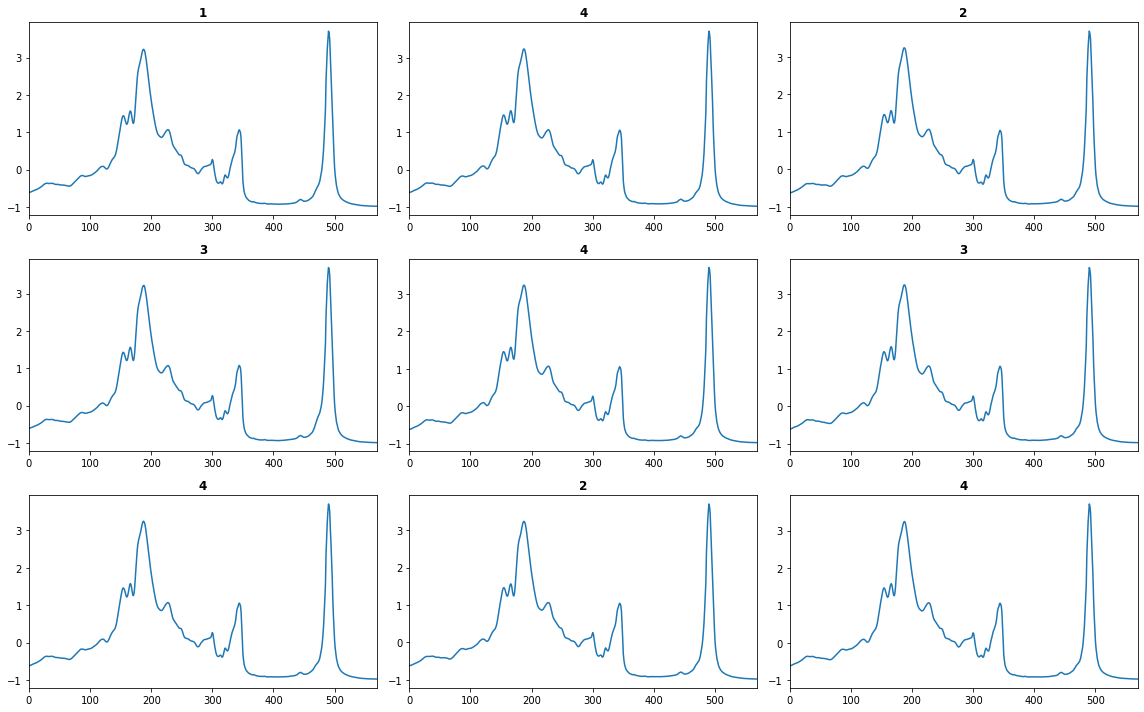

In [4]:
tfms = [None, Categorize()]
batch_tfms = [TSStandardize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

Even if these look like images, the actual data passed to the model is the raw data (batch_size x channels x sequence lentgh). 

This is different from the TS to image transforms that will see in a moment, in which the batch contains actual images. 

epoch,train_loss,valid_loss,accuracy,time
0,1.640187,1.415816,0.133333,00:00
1,1.622343,1.412785,0.133333,00:00
2,1.605910,1.410884,0.133333,00:00
3,1.590820,1.409809,0.133333,00:00
4,1.576753,1.409244,0.133333,00:00
5,1.563432,1.408907,0.133333,00:00
6,1.550565,1.408680,0.133333,00:00
7,1.538086,1.408431,0.133333,00:00
8,1.525948,1.408074,0.133333,00:00
9,1.514122,1.407572,0.133333,00:00


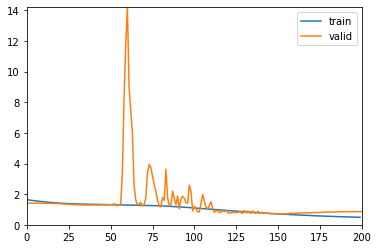


training time: 00:00:43


In [5]:
model = create_model(InceptionTime, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToPlot

All of these transforms are applied as batch transforms. We can use the same TSDatasets and TSDataLoaders we always use.

Some of these transforms require a previous normalization (TSToMat, TSToGASF, TSToGADF, TSToRP). In general, I'd recommend you to use TSNormalize in all cases. By default this transform will normalize each sample between (-1, 1), although you can also choose the option by_sample=False, in which case, it will normalize based on the entire training set. 

We'll train a vision model. In our case, we'll use xresnet34, which is part of the fastai library.

I will train all models in the same way, without any hyperparameter optimization. 

In the case of univariate time series, you may also pass a matplotlib cmap to the transform (all except TSToPlot). Bear in mind that all these transforms will create a 1 channel image for each variable (1 in the case of univariate TS). This may be converted into a 3 channel image by applying a cmap. This will add extra time to the batch creation process but in some cased it improves performance. 

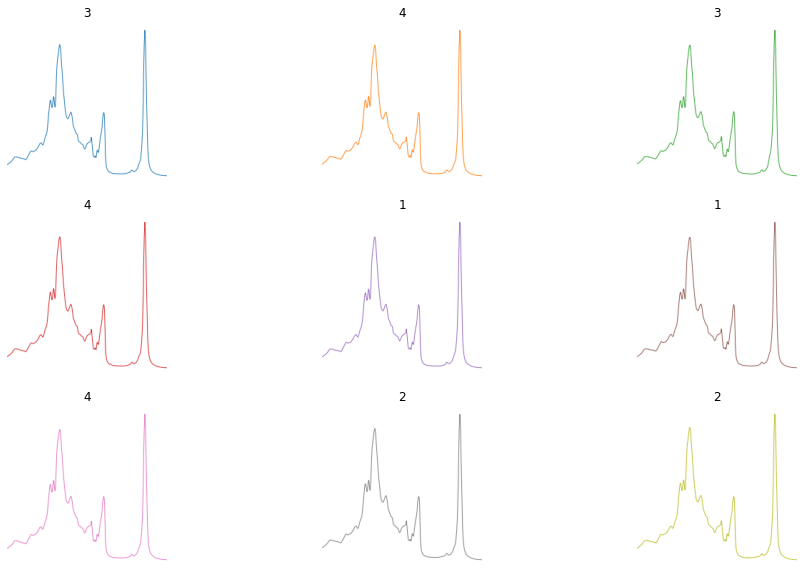

In [6]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToPlot()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.522350,1.814902,0.166667,00:00
1,1.521043,1.541529,0.166667,00:00
2,1.533010,1.434697,0.166667,00:00
3,1.543399,1.425153,0.400000,00:00
4,1.555793,1.469467,0.400000,00:00
5,1.556613,1.540474,0.400000,00:00
6,1.549800,1.606365,0.400000,00:00
7,1.546509,1.667264,0.400000,00:00
8,1.540340,1.715062,0.400000,00:00
9,1.527422,1.748701,0.400000,00:00


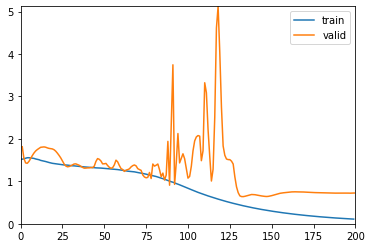


training time: 00:01:39


In [7]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToMat

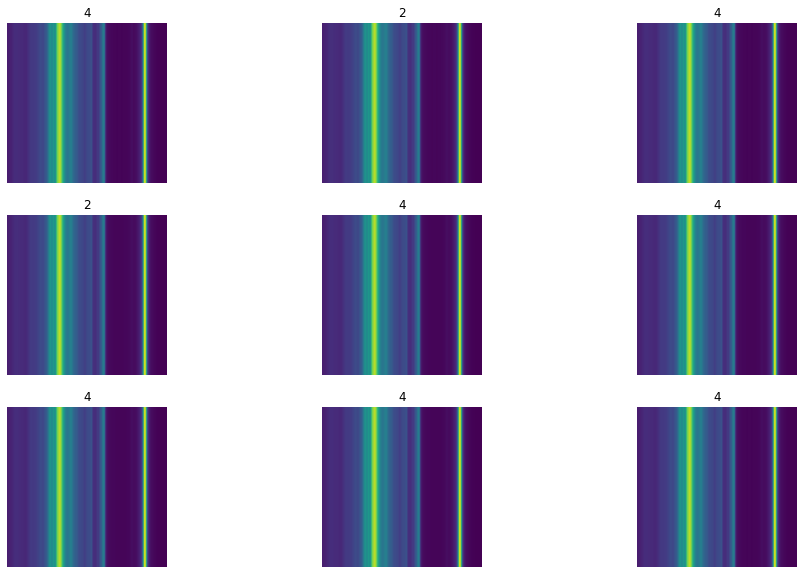

In [8]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

One of the options you have is to use a pretrained model and just fine tune it, or train it entirely from scratch. Let's see how you could test this.

epoch,train_loss,valid_loss,accuracy,time
0,1.384554,1.307747,0.400000,00:00


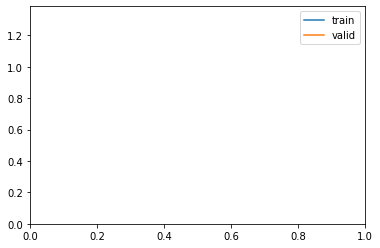

epoch,train_loss,valid_loss,accuracy,time
0,1.357212,1.349977,0.400000,00:00
1,1.333271,1.356470,0.400000,00:00
2,1.313750,1.350068,0.400000,00:00
3,1.298261,1.346738,0.400000,00:00
4,1.285365,1.345156,0.400000,00:00
5,1.274466,1.344199,0.400000,00:00
6,1.264903,1.342696,0.400000,00:00
7,1.256357,1.341716,0.400000,00:00
8,1.248502,1.341993,0.400000,00:00
9,1.241190,1.342292,0.400000,00:00


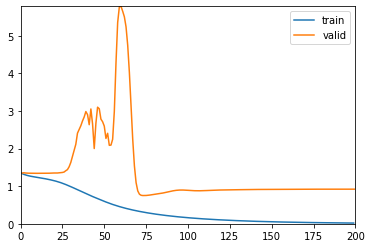


training time: 00:03:18


In [9]:
model = create_model(xresnet34, dls=dls, pretrained=True)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fine_tune(epochs)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

epoch,train_loss,valid_loss,accuracy,time
0,1.685959,1.431023,0.300000,00:00
1,1.671753,1.414136,0.300000,00:00
2,1.658169,1.449791,0.133333,00:00
3,1.644883,1.459251,0.133333,00:00
4,1.631772,1.452308,0.133333,00:00
5,1.618534,1.435338,0.133333,00:00
6,1.604917,1.423056,0.133333,00:00
7,1.590829,1.405057,0.133333,00:00
8,1.576351,1.387827,0.133333,00:00
9,1.561334,1.375111,0.400000,00:00


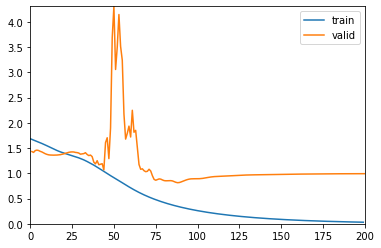


training time: 00:03:18


In [10]:
model = create_model(xresnet34, dls=dls) # by default xresnet models are pretrained=False
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

In this case these 2 approaches have the same performance. We'll test this again later with a multivariate dataset. 

### TSToGADF

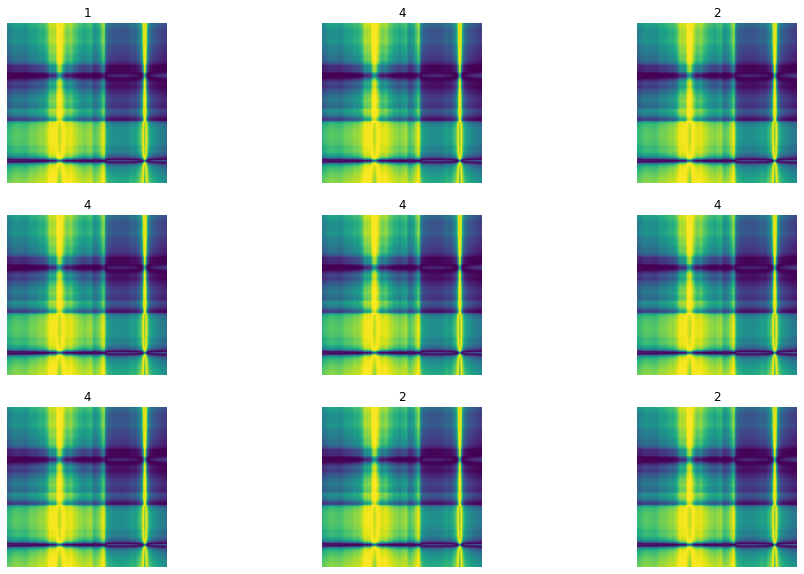

In [11]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToGADF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.296988,1.333992,0.400000,00:00
1,1.294667,1.307575,0.400000,00:00
2,1.292565,1.312512,0.400000,00:00
3,1.290587,1.329236,0.400000,00:00
4,1.288711,1.346779,0.400000,00:00
5,1.286904,1.363090,0.400000,00:00
6,1.285140,1.376518,0.166667,00:00
7,1.283424,1.387498,0.166667,00:00
8,1.281752,1.397334,0.166667,00:00
9,1.280128,1.407056,0.166667,00:00


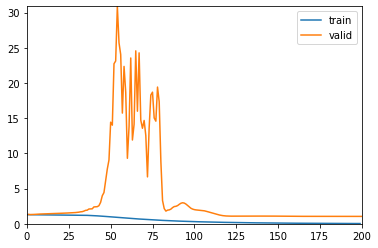


training time: 00:00:58


In [12]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToGASF

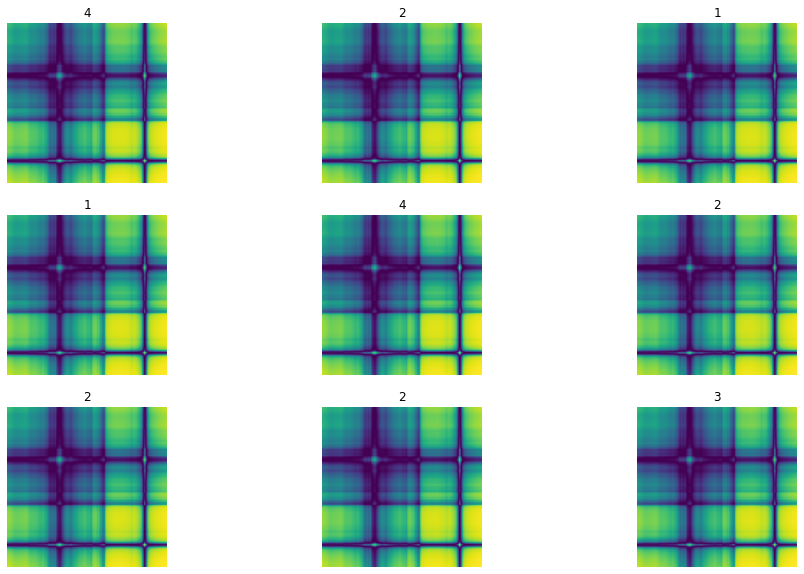

In [13]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToGASF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.607446,2.007170,0.133333,00:00
1,1.599502,1.815625,0.133333,00:00
2,1.591692,1.704227,0.133333,00:00
3,1.583877,1.640764,0.133333,00:00
4,1.575917,1.607884,0.133333,00:00
5,1.567684,1.586597,0.133333,00:00
6,1.559051,1.570800,0.133333,00:00
7,1.549967,1.554640,0.133333,00:00
8,1.540437,1.540914,0.133333,00:00
9,1.530430,1.529050,0.133333,00:00


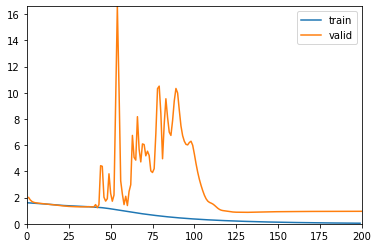


training time: 00:00:59


In [14]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToMTF

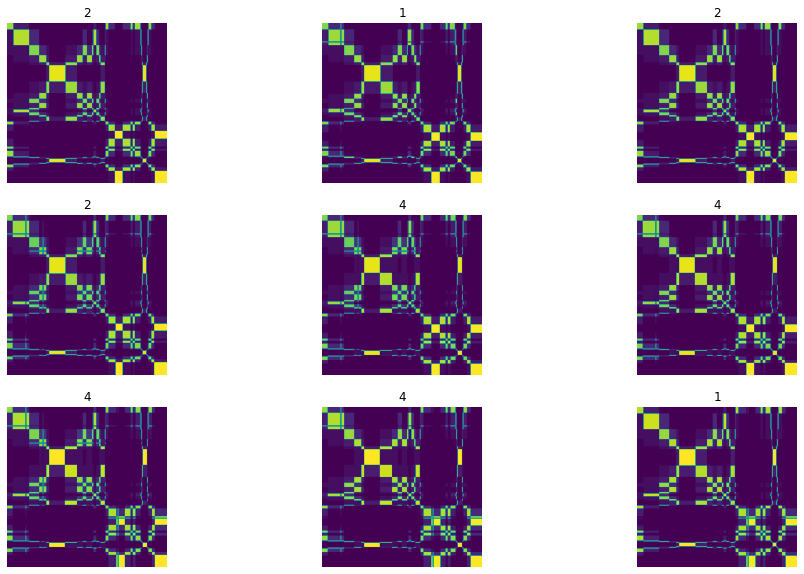

In [20]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMTF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.512816,1.424081,0.133333,00:00
1,1.504091,1.412253,0.133333,00:00
2,1.495380,1.400981,0.133333,00:00
3,1.486525,1.392035,0.133333,00:00
4,1.477335,1.385283,0.133333,00:00
5,1.467639,1.380457,0.133333,00:00
6,1.457318,1.377529,0.133333,00:00
7,1.446259,1.375103,0.266667,00:00
8,1.434392,1.372780,0.400000,00:00
9,1.421703,1.369490,0.366667,00:00


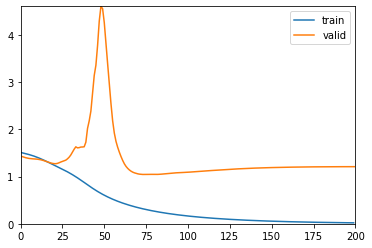


training time: 00:00:52


In [21]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToRP

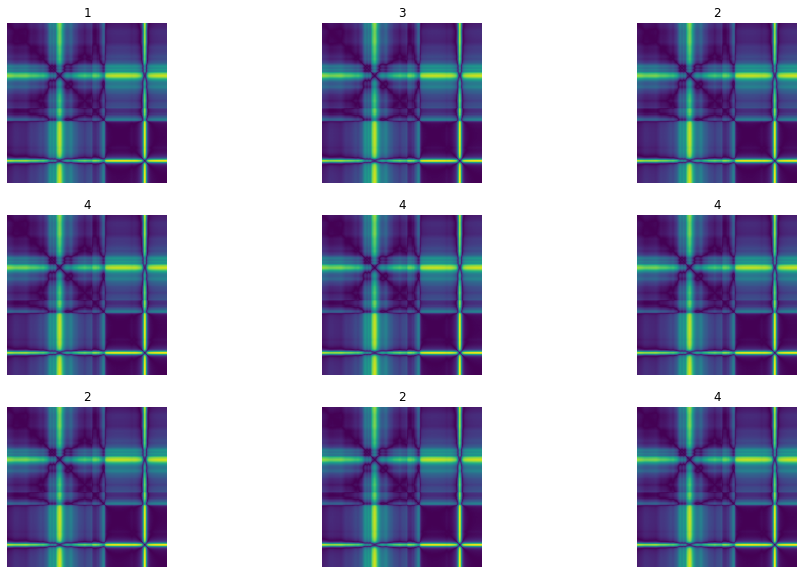

In [22]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(by_sample=True, range=(0,1)), TSToRP()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.341933,1.388604,0.166667,00:00
1,1.338176,1.376714,0.400000,00:00
2,1.334609,1.372304,0.400000,00:00
3,1.331132,1.368433,0.400000,00:00
4,1.327691,1.365139,0.400000,00:00
5,1.324228,1.361678,0.400000,00:00
6,1.320711,1.359131,0.400000,00:00
7,1.317145,1.357056,0.400000,00:00
8,1.313540,1.355834,0.400000,00:00
9,1.309933,1.355344,0.400000,00:00


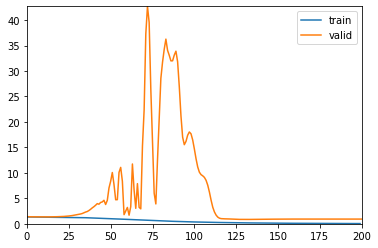


training time: 00:00:52


In [23]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

## Multivariate

In the case of multivariate time series they are used in the same way. 

The only differences are: 

* You may normalize data based on the training dataset or by sample. In either case you may also do it by variable (by_var=True) or not. 
* You won't be able to pass a cmap as multivariate time series will create a one channel image for each of the time series variables. 

In [26]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', return_split=False)
epochs = 100

### Raw data (InceptionTime)

epoch,train_loss,valid_loss,accuracy,time
0,1.836315,1.837149,0.166667,00:00
1,1.767591,1.828633,0.166667,00:00
2,1.705396,1.820488,0.166667,00:00
3,1.623672,1.813031,0.166667,00:00
4,1.542436,1.804569,0.172222,00:00
5,1.458545,1.792188,0.177778,00:00
6,1.372356,1.771467,0.177778,00:00
7,1.285567,1.735013,0.238889,00:00
8,1.202932,1.669825,0.472222,00:00
9,1.128803,1.557010,0.600000,00:00


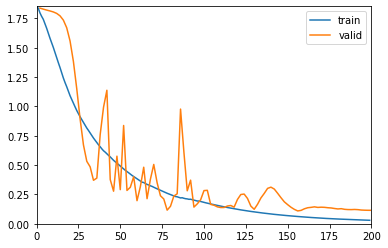


training time: 00:00:23


In [27]:
tfms = [TSStandardize(verbose=True), Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=None)
model = create_model(InceptionTime, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToPlot

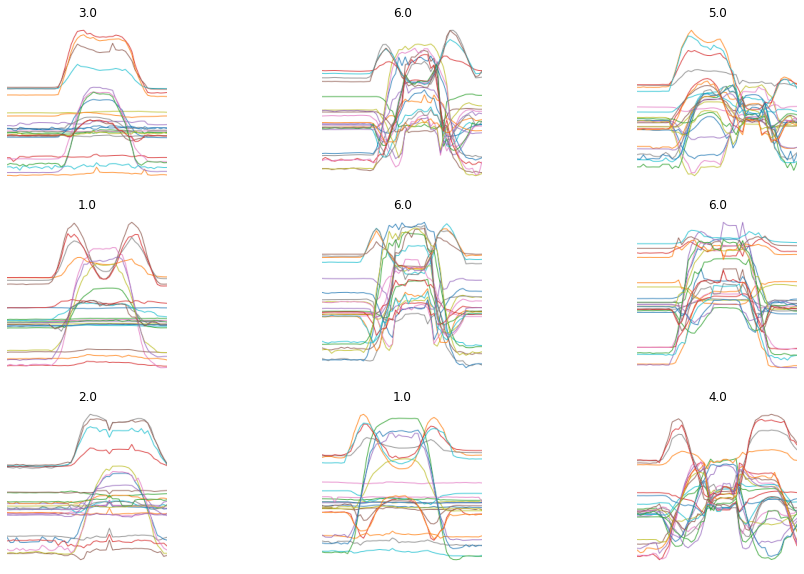

In [28]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToPlot()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.988043,2.017329,0.166667,00:06
1,1.970007,1.945643,0.166667,00:05
2,1.947891,1.933763,0.172222,00:05
3,1.920103,1.905865,0.216667,00:05
4,1.898317,1.889220,0.172222,00:05
5,1.866565,1.909821,0.166667,00:05
6,1.836643,1.923480,0.172222,00:05
7,1.801250,1.923493,0.194444,00:05
8,1.759394,1.921263,0.177778,00:05
9,1.716779,1.904289,0.166667,00:05


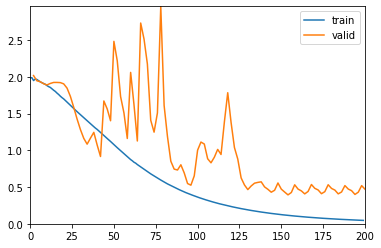


training time: 00:08:55


In [29]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToMat

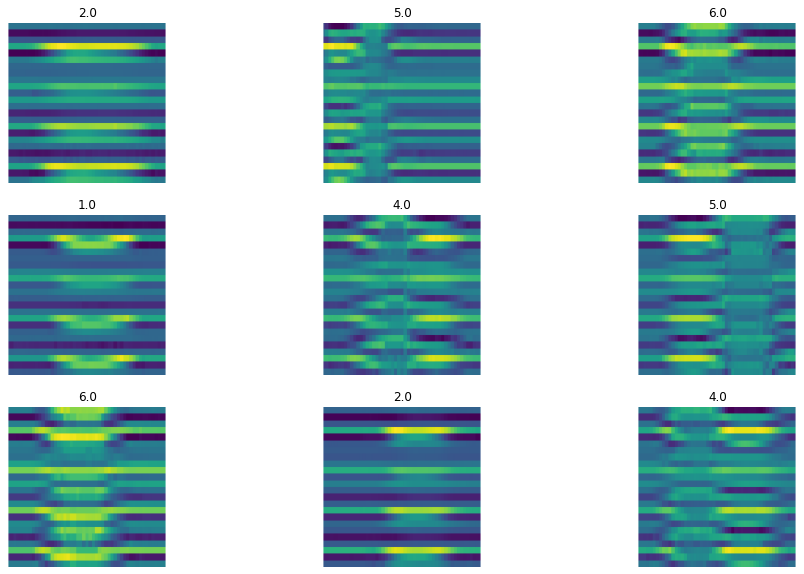

In [30]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
xb,yb = first(dls.train)
dls.show_batch()

Let's check again if there's any difference between training a pre-trained model and training it from scratch.

epoch,train_loss,valid_loss,accuracy,time
0,1.834608,1.801193,0.155556,00:02


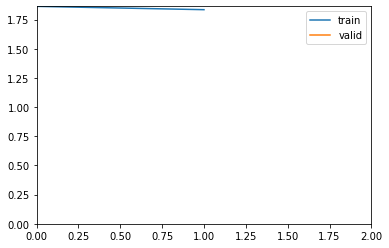

epoch,train_loss,valid_loss,accuracy,time
0,1.452266,1.782030,0.188889,00:01
1,1.385030,1.795413,0.177778,00:01
2,1.334845,1.823962,0.177778,00:02
3,1.287235,1.843883,0.244444,00:01
4,1.236544,1.841469,0.305556,00:01
5,1.195034,1.811436,0.233333,00:01
6,1.154667,1.763024,0.183333,00:01
7,1.116765,1.707211,0.338889,00:01
8,1.081709,1.648664,0.350000,00:01
9,1.047397,1.597615,0.344444,00:01


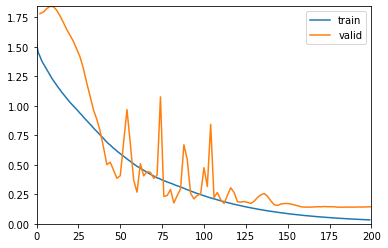


training time: 00:03:31


In [31]:
model = create_model(xresnet34, dls=dls, pretrained=True)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fine_tune(epochs)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

epoch,train_loss,valid_loss,accuracy,time
0,1.946822,1.800407,0.166667,00:01
1,1.926802,1.799463,0.166667,00:02
2,1.892566,1.817616,0.166667,00:01
3,1.867902,1.814256,0.166667,00:01
4,1.828533,1.805557,0.205556,00:01
5,1.789295,1.797099,0.216667,00:01
6,1.744733,1.790718,0.188889,00:01
7,1.695636,1.784735,0.172222,00:01
8,1.641091,1.781376,0.172222,00:01
9,1.587173,1.773180,0.172222,00:02


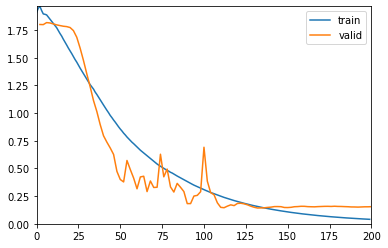


training time: 00:03:34


In [32]:
model = create_model(xresnet34, dls=dls) # not pretrained
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToGADF

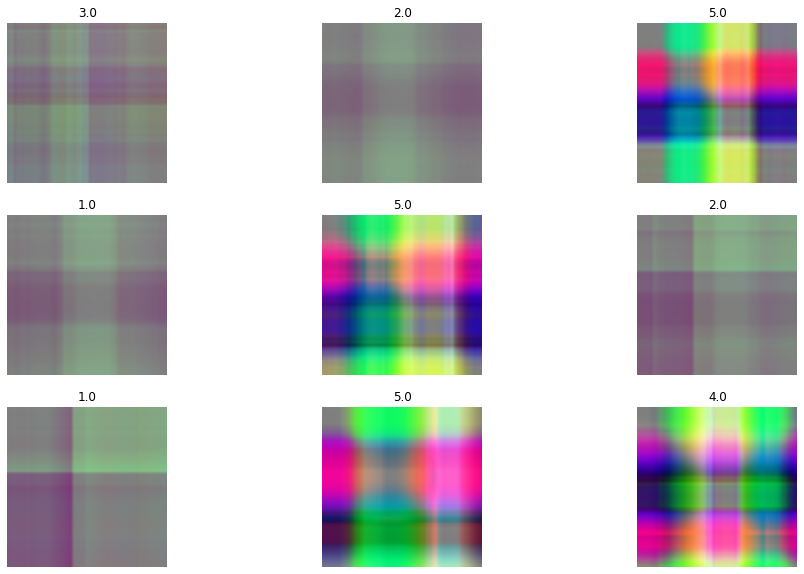

In [33]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToGADF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.885496,1.799144,0.166667,00:03
1,1.854638,1.794496,0.122222,00:03
2,1.828292,1.794173,0.166667,00:03
3,1.790019,1.785543,0.105556,00:03
4,1.744891,1.753700,0.172222,00:03
5,1.692161,1.706027,0.188889,00:03
6,1.628416,1.645858,0.255556,00:03
7,1.562620,1.562221,0.361111,00:03
8,1.495271,1.448490,0.538889,00:03
9,1.428274,1.302268,0.666667,00:03


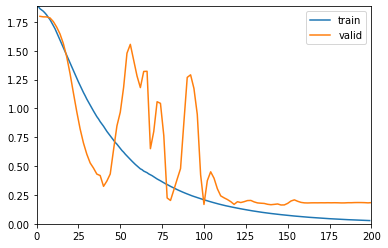


training time: 00:05:55


In [34]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToGASF

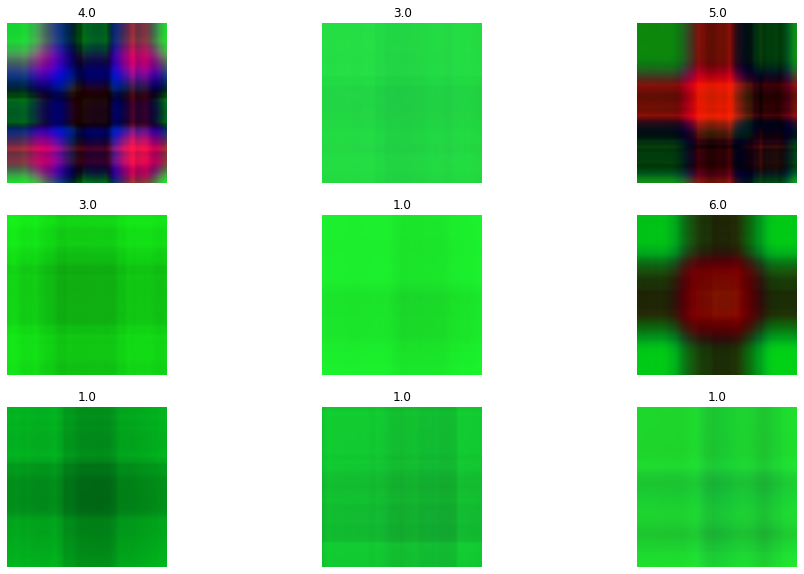

In [35]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToGASF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.965722,1.772245,0.155556,00:03
1,1.926952,1.798062,0.177778,00:03
2,1.888404,1.801582,0.205556,00:03
3,1.842753,1.791387,0.255556,00:03
4,1.789382,1.768596,0.261111,00:03
5,1.728767,1.730473,0.277778,00:03
6,1.659237,1.676467,0.283333,00:03
7,1.588725,1.598202,0.294444,00:03
8,1.517166,1.495316,0.333333,00:03
9,1.445266,1.374113,0.433333,00:03


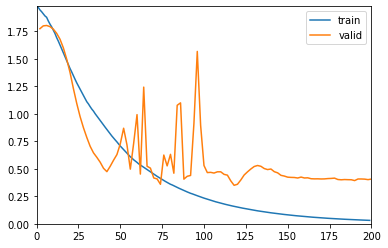


training time: 00:05:50


In [36]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToMTF

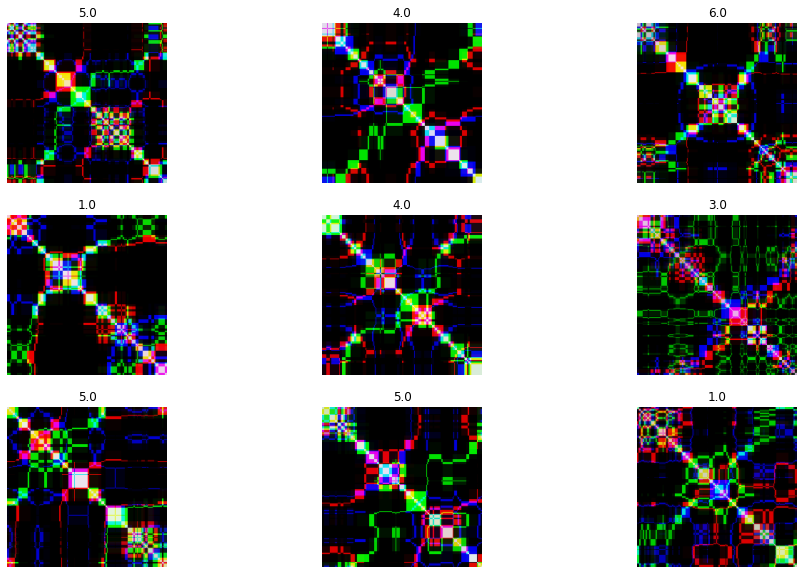

In [37]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMTF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.919840,1.795954,0.166667,00:03
1,1.896983,1.795453,0.155556,00:03
2,1.886470,1.798174,0.166667,00:03
3,1.864096,1.797973,0.166667,00:03
4,1.846468,1.793960,0.166667,00:03
5,1.825032,1.785105,0.161111,00:03
6,1.800950,1.770468,0.166667,00:03
7,1.771521,1.751316,0.188889,00:03
8,1.740799,1.727810,0.333333,00:03
9,1.708176,1.699032,0.350000,00:03


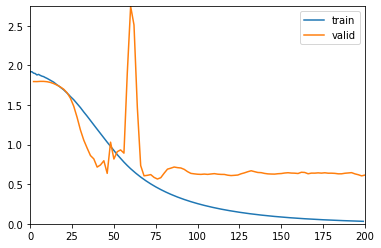


training time: 00:06:12


In [38]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

### TSToRP

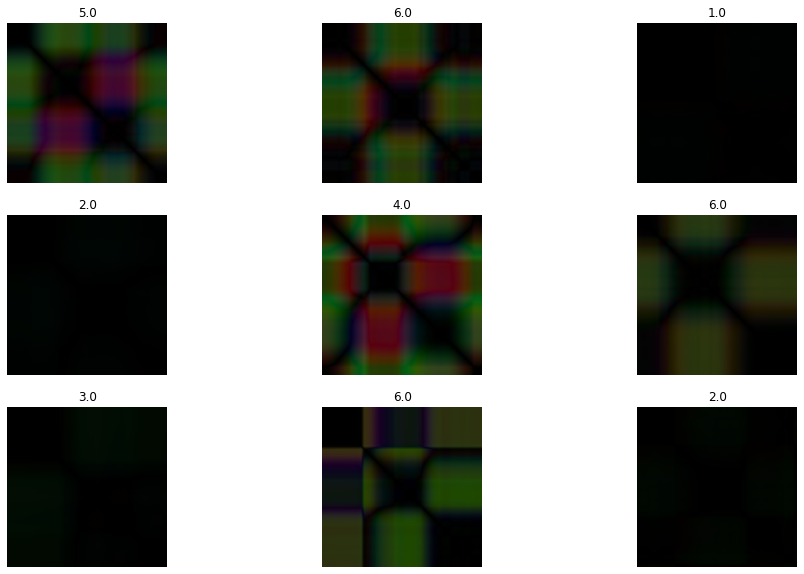

In [39]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(by_sample=True, range=(0,1)), TSToRP()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.904231,1.797877,0.027778,00:02
1,1.853544,1.809920,0.033333,00:02
2,1.819230,1.825675,0.122222,00:02
3,1.761951,1.838475,0.155556,00:02
4,1.702472,1.842272,0.155556,00:02
5,1.639545,1.833330,0.155556,00:02
6,1.562481,1.814887,0.150000,00:02
7,1.490228,1.791165,0.300000,00:02
8,1.408856,1.771616,0.216667,00:02
9,1.329353,1.764667,0.166667,00:02


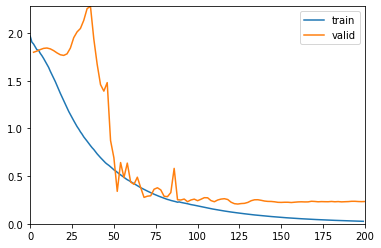


training time: 00:04:29


In [40]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

## Additional TS transforms

Since all TS to image transforms are applied "on the fly", this means that you can apply other transforms before or after the image is created. 

You may use any of the TS transforms available before the image is create. Let's demonstrate how this is done: 

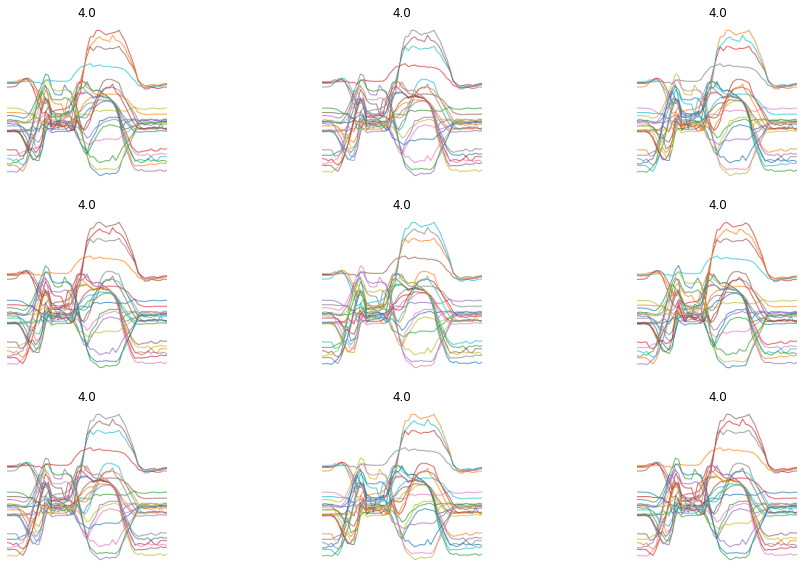

In [43]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', return_split=False)
tfms = [None, Categorize()]
batch_tfms = [TSMagScale(p=0.5), TSWindowWarp(p=0.5), TSNormalize(), TSToPlot()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch(unique=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.905431,2.330801,0.166667,00:05
1,1.908425,2.233084,0.194444,00:05
2,1.880373,2.172419,0.166667,00:05
3,1.863088,2.155142,0.166667,00:05
4,1.841232,2.137905,0.166667,00:05
5,1.824895,2.052852,0.166667,00:05
6,1.798581,1.980040,0.216667,00:05
7,1.772900,1.933715,0.166667,00:05
8,1.741708,1.901900,0.166667,00:05
9,1.708913,1.870197,0.166667,00:05


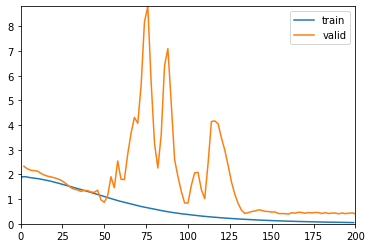


training time: 00:09:22


In [44]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback())
start = time.time()
learn.fit_one_cycle(epochs, max_lr=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

## Conclusion

As you have seen, these transforms are competitive if you compare them to a state-of-the-art raw TS model like InceptionTime (that take a 3d input - bs x nvars x seq_len) instead of the image models that take 4d inputs.

There are many ways in which you can transform univariate or multivariate time series into images. 

There are many options to explore all of this: 

* You can use many different TS to image transformations 
* You can also use different cmaps
* You can choose different image sizes
* You can normalize data by sample and/ or by_channel
* You can use pretrained models or train from scratch
* You can combine TS to image transforms with other transforms
* You can use different vision models
* You can apply vision transforms
...

I hope you find this useful as an introduction to this field. 